In [44]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib
import warnings

In [ ]:
e_list = [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
# Lista de parâmetros n para iterar
e_list = range(16, 50, 1)

In [45]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Parâmetros adicionais
n = 14
d = 60
t = 14
e_list = range(55, 150, 1)
alpha = 0.05  # Mantemos um único valor de alpha

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)




price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Loop para calcular e salvar a variável para cada valor de 'e'
for e in e_list:
    # Calcula o Price Rate of Change para o valor atual de 'e'
    price_data[f'Price_Rate_Of_Change_{e}'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
        lambda x: x.pct_change(periods=e)
    )

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent


# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()
warnings.filterwarnings("ignore")
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_55,Price_Rate_Of_Change_56,Price_Rate_Of_Change_57,Price_Rate_Of_Change_58,Price_Rate_Of_Change_59,Price_Rate_Of_Change_60,Price_Rate_Of_Change_61,Price_Rate_Of_Change_62,Price_Rate_Of_Change_63,Price_Rate_Of_Change_64,Price_Rate_Of_Change_65,Price_Rate_Of_Change_66,Price_Rate_Of_Change_67,Price_Rate_Of_Change_68,Price_Rate_Of_Change_69,Price_Rate_Of_Change_70,Price_Rate_Of_Change_71,Price_Rate_Of_Change_72,Price_Rate_Of_Change_73,Price_Rate_Of_Change_74,Price_Rate_Of_Change_75,Price_Rate_Of_Change_76,Price_Rate_Of_Change_77,Price_Rate_Of_Change_78,Price_Rate_Of_Change_79,Price_Rate_Of_Change_80,Price_Rate_Of_Change_81,Price_Rate_Of_Change_82,Price_Rate_Of_Change_83,Price_Rate_Of_Change_84,Price_Rate_Of_Change_85,Price_Rate_Of_Change_86,Price_Rate_Of_Change_87,Price_Rate_Of_Change_88,Price_Rate_Of_Change_89,Price_Rate_Of_Change_90,Price_Rate_Of_Change_91,Price_Rate_Of_Change_92,Price_Rate_Of_Change_93,Price_Rate_Of_Change_94,Price_Rate_Of_Change_95,Price_Rate_Of_Change_96,Price_Rate_Of_Change_97,Price_Rate_Of_Change_98,Price_Rate_Of_Change_99,Price_Rate_Of_Change_100,Price_Rate_Of_Change_101,Price_Rate_Of_Change_102,Price_Rate_Of_Change_103,Price_Rate_Of_Change_104,Price_Rate_Of_Change_105,Price_Rate_Of_Change_106,Price_Rate_Of_Change_107,Price_Rate_Of_Change_108,Price_Rate_Of_Change_109,Price_Rate_Of_Change_110,Price_Rate_Of_Change_111,Price_Rate_Of_Change_112,Price_Rate_Of_Change_113,Price_Rate_Of_Change_114,Price_Rate_Of_Change_115,Price_Rate_Of_Change_116,Price_Rate_Of_Change_117,Price_Rate_Of_Change_118,Price_Rate_Of_Change_119,Price_Rate_Of_Change_120,Price_Rate_Of_Change_121,Price_Rate_Of_Change_122,Price_Rate_Of_Change_123,Price_Rate_Of_Change_124,Price_Rate_Of_Change_125,Price_Rate_Of_Change_126,Price_Rate_Of_Change_127,Price_Rate_Of_Change_128,Price_Rate_Of_Change_129,Price_Rate_Of_Change_130,Price_Rate_Of_Change_131,Price_Rate_Of_Change_132,Price_Rate_Of_Change_133,Price_Rate_Of_Change_134,Price_Rate_Of_Change_135,Price_Rate_Of_Change_136,Price_Rate_Of_Change_137,Price_Rate_Of_Change_138,Price_Rate_Of_Change_139,Price_Rate_Of_Change_140,Price_Rate_Of_Change_141,Price_Rate_Of_Change_142,Price_Rate_Of_Change_143,Price_Rate_Of_Change_144,Price_Rate_Of_Change_145,Price_Rate_Of_Change_146,Price_Rate_Of_Change_147,Price_Rate_Of_Change_148,Price_Rate_Of_Change_149,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,On Balance Volume,Close_10
11719,2024-10-21,61.349998,61.380001,60.270000,60.330002,59.796291,19044900,VALE3.SA,-0.219997,60.598574,-1.0,-0.013691,-0.017411,-0.019304,-0.020590,-0.020792,-0.022177,-0.022503,-0.022937,-0.024139,-0.025376,-0.026979,-0.027989,-0.028992,-0.030004,-0.030595,-0.030743,-0.030360,-0.030013,-0.030392,-0.030660,-0.030248,-0.029748,-0.028812,-0.027612,-0.026081,-0.025497,-0.024708,-0.024637,-0.025107,-0.025733,-0.027009,-0.028143,-0.029391,-0.030236,-0.031572,-0.033128,-0.034988,-0.036745,-0.038418,-0.040725,-0.042473,-0.044235,-0.046604,-0.048456,-0.051055,-0.053099,-0.054753,-0.055457,-0.056167,-0.056410,-0.055575,-0.054866,-0.054141,-0.053073,-0.051540,-0.049772,-0.047881,-0.046884,-0.046205,-0.045338,-0.044393,-0.043697,-0.042789,-0.042245,-0.041202,-0.040421,-0.039749,-0.039098,-0.038917,-0.038236,-0.038869,-0.038459,-0.038653,-0.038417,-0.038143,-0.038674,-0.039417,-0.040734,-0.041678,-0.042955,-0.044114,-0.045537,-0.046280,-0.046729,-0.049765,-0.052426,-0.054683,-0.056360,-0.058673,-0.061393,-0.064415,-0.067991,-0.071148,-0.074352,-0.077176,0.219997,0.000000,39.561996,60.330002,-1.0,60.250000,65.349998,6.834786,-93.165214,0.391453,0.312635,4210887480,54.020000
11720,2024-10-22,60.150002,60.660000,59.900002,60.410000,59.875580,14814000,VALE3.SA,0.079998,60.589145,-1.0,-0.010519,-0.013844,-0.017564,-0.019457,-0.020742,-0.020944,-0.022329,-0.022655,-0.023090,-0.024291,-0.025528,-0.027131,-0.028140,-0.029143,-0.030155,-0.030746

In [46]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_55,Price_Rate_Of_Change_56,Price_Rate_Of_Change_57,Price_Rate_Of_Change_58,Price_Rate_Of_Change_59,Price_Rate_Of_Change_60,Price_Rate_Of_Change_61,Price_Rate_Of_Change_62,Price_Rate_Of_Change_63,Price_Rate_Of_Change_64,Price_Rate_Of_Change_65,Price_Rate_Of_Change_66,Price_Rate_Of_Change_67,Price_Rate_Of_Change_68,Price_Rate_Of_Change_69,Price_Rate_Of_Change_70,Price_Rate_Of_Change_71,Price_Rate_Of_Change_72,Price_Rate_Of_Change_73,Price_Rate_Of_Change_74,Price_Rate_Of_Change_75,Price_Rate_Of_Change_76,Price_Rate_Of_Change_77,Price_Rate_Of_Change_78,Price_Rate_Of_Change_79,Price_Rate_Of_Change_80,Price_Rate_Of_Change_81,Price_Rate_Of_Change_82,Price_Rate_Of_Change_83,Price_Rate_Of_Change_84,Price_Rate_Of_Change_85,Price_Rate_Of_Change_86,Price_Rate_Of_Change_87,Price_Rate_Of_Change_88,Price_Rate_Of_Change_89,Price_Rate_Of_Change_90,Price_Rate_Of_Change_91,Price_Rate_Of_Change_92,Price_Rate_Of_Change_93,Price_Rate_Of_Change_94,Price_Rate_Of_Change_95,Price_Rate_Of_Change_96,Price_Rate_Of_Change_97,Price_Rate_Of_Change_98,Price_Rate_Of_Change_99,Price_Rate_Of_Change_100,Price_Rate_Of_Change_101,Price_Rate_Of_Change_102,Price_Rate_Of_Change_103,Price_Rate_Of_Change_104,Price_Rate_Of_Change_105,Price_Rate_Of_Change_106,Price_Rate_Of_Change_107,Price_Rate_Of_Change_108,Price_Rate_Of_Change_109,Price_Rate_Of_Change_110,Price_Rate_Of_Change_111,Price_Rate_Of_Change_112,Price_Rate_Of_Change_113,Price_Rate_Of_Change_114,Price_Rate_Of_Change_115,Price_Rate_Of_Change_116,Price_Rate_Of_Change_117,Price_Rate_Of_Change_118,Price_Rate_Of_Change_119,Price_Rate_Of_Change_120,Price_Rate_Of_Change_121,Price_Rate_Of_Change_122,Price_Rate_Of_Change_123,Price_Rate_Of_Change_124,Price_Rate_Of_Change_125,Price_Rate_Of_Change_126,Price_Rate_Of_Change_127,Price_Rate_Of_Change_128,Price_Rate_Of_Change_129,Price_Rate_Of_Change_130,Price_Rate_Of_Change_131,Price_Rate_Of_Change_132,Price_Rate_Of_Change_133,Price_Rate_Of_Change_134,Price_Rate_Of_Change_135,Price_Rate_Of_Change_136,Price_Rate_Of_Change_137,Price_Rate_Of_Change_138,Price_Rate_Of_Change_139,Price_Rate_Of_Change_140,Price_Rate_Of_Change_141,Price_Rate_Of_Change_142,Price_Rate_Of_Change_143,Price_Rate_Of_Change_144,Price_Rate_Of_Change_145,Price_Rate_Of_Change_146,Price_Rate_Of_Change_147,Price_Rate_Of_Change_148,Price_Rate_Of_Change_149,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,On Balance Volume,Close_10
5686,2024-10-17,12.78,12.96,12.75,12.86,12.613667,18266900,ABEV3.SA,-0.08,12.895616,-1.0,0.110008,0.110876,0.111740,0.112803,0.113519,0.113970,0.115206,0.115900,0.116325,0.116774,0.116686,0.115933,0.114380,0.112751,0.111393,0.110622,0.109459,0.108639,0.107728,0.106569,0.105602,0.104536,0.103069,0.101231,0.099106,0.096878,0.094151,0.091539,0.088754,0.085837,0.082067,0.078982,0.076367,0.073910,0.071805,0.070814,0.068606,0.066848,0.064357,0.061793,0.058924,0.056240,0.054426,0.052795,0.051490,0.050164,0.048997,0.048130,0.048473,0.048834,0.048901,0.048298,0.047216,0.045990,0.044747,0.043976,0.045078,0.045572,0.045734,0.045727,0.044917,0.043843,0.042315,0.040756,0.039209,0.036794,0.034658,0.032418,0.030115,0.027486,0.024861,0.022668,0.020581,0.018733,0.016373,0.014992,0.012747,0.010645,0.009438,0.008088,0.005927,0.003909,0.002449,0.000754,-0.001920,-0.003180,-0.004787,-0.006472,-0.007879,-0.009355,-0.010225,-0.011339,-0.012309,-0.013924,-0.015461,0.08,0.00,36.610573,12.86,-1.0,12.72,13.85,15.541249,-84.458751,0.144057,0.154677,-2239069075,11.25
5687,2024-10-18,12.96,12.96,12.80,12.88,12.633285,19422900,ABEV3.SA,0.02,12.894836,-1.0,0.108832,0.109941,0.110809,0.111673,0.112736,0.113452,0.113903,0.115138,0.115832,0.116258,0.116706,0.116619,0.115865,0.114313,0.112683,0.111326,0.110555,0.109392,0.108572,0.107660,0.106502,0.105535,0.104469,0.103002,0.101164,0.099039,0.096811,0.094085,0.091472,0.088688,0.085772,0.082002,0.078916,0.076302,0

e: 55
Fold 1:
 - Correct Prediction (y_test): 38.89%
 - Correct Prediction (Verify): 44.42%
Fold 2:
 - Correct Prediction (y_test): 46.91%
 - Correct Prediction (Verify): 52.87%
Fold 3:
 - Correct Prediction (y_test): 62.73%
 - Correct Prediction (Verify): 56.34%
Fold 4:
 - Correct Prediction (y_test): 49.51%
 - Correct Prediction (Verify): 44.20%
Fold 5:
 - Correct Prediction (y_test): 50.16%
 - Correct Prediction (Verify): 45.50%
Média de acurácia (y_test) para e 55: 49.64%
Média de acurácia (Verify) para e 55: 48.67%
---
e: 56
Fold 1:
 - Correct Prediction (y_test): 39.65%
 - Correct Prediction (Verify): 44.96%
Fold 2:
 - Correct Prediction (y_test): 48.32%
 - Correct Prediction (Verify): 54.93%
Fold 3:
 - Correct Prediction (y_test): 61.54%
 - Correct Prediction (Verify): 53.41%
Fold 4:
 - Correct Prediction (y_test): 50.92%
 - Correct Prediction (Verify): 44.96%
Fold 5:
 - Correct Prediction (y_test): 49.62%
 - Correct Prediction (Verify): 45.83%
Média de acurácia (y_test) para e 

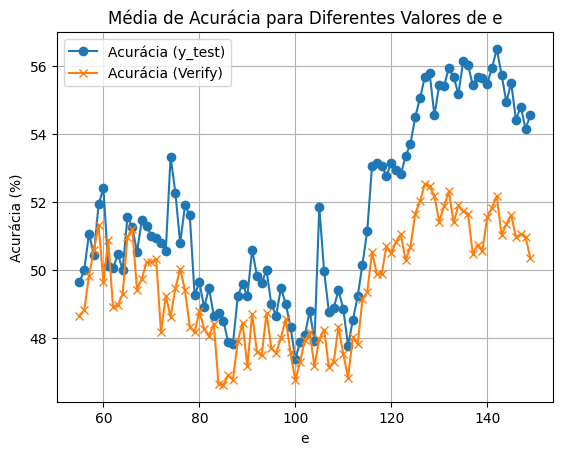

In [47]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por e
mean_accuracy_by_e = []

# Loop para cada e em n_list e realização de validação cruzada em série temporal
for e in e_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    f'Price_Rate_Of_Change_{e}',
                    'MACD',
                    'MACD_EMA',
                    'On Balance Volume']]
    y = price_data['Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse e
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'e: {e}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por e
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_e.append((e, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para e {e}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para e {e}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for e, acc_ytest, acc_verify in mean_accuracy_by_e:
    print(f'e: {e} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por e
import matplotlib.pyplot as plt

e_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_e)

plt.plot(e_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(e_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de e")
plt.xlabel('e')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)